In [1]:
import fastai; fastai.__version__

'1.0.46.dev0'

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
import string

# create data

In [3]:
# path = untar_data(URLs.PETS, dest='/data/fastai/')
path = untar_data(URLs.PETS, dest='~/data/fastai/')

path.ls()

[PosixPath('~/data/fastai/oxford-iiit-pet/images'),
 PosixPath('~/data/fastai/oxford-iiit-pet/models'),
 PosixPath('~/data/fastai/oxford-iiit-pet/annotations')]

In [4]:
path_anno = path/'annotations'
path_img = path/'images'

In [5]:
# fastai
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)
def _get_label(fn): 
    if isinstance(fn, Path): fn = fn.as_posix()
    res = pat.search(str(fn))
    assert res,f'Failed to find "{pat}" in "{fn}"'
    return res.group(1)

In [6]:
imgs = np.random.choice([o for o in path_img.ls() if o.suffix=='.jpg'], 1000)

np.random.seed(42)
cat1 = [_get_label(o) for o in imgs]
cat2 = np.random.choice(list(['A', 'B']), len(imgs))
mcat1 = [np.random.choice(list(['x', 'y', 'z']), np.random.choice(range(3)), replace=False) for _ in range(len(imgs))]
mcat2 = [np.random.choice(list(['ccc', 'sss', 'nnn', 'www']), np.random.choice(range(4)), replace=False) 
         for _ in range(len(imgs))]
num1 = [np.random.randn() for _ in range(len(imgs))]
num2 = [np.random.rand() for _ in range(len(imgs))]

df_full = pd.DataFrame({'img': [o.stem for o in imgs], 
                  'cat1': cat1, 'cat2': cat2, 
                   'mcat1': [" ".join(o) for o in mcat1],
                   'mcat2': [" ".join(o) for o in mcat2],
                   'num1': num1,
                   'num2': num2,
                  })
df_full['is_valid'] = np.random.choice([True,False], len(df_full), p=[0.2, 0.8])

In [7]:
df_full.shape

(1000, 8)

In [8]:
df_full.sample(10)

,img,cat1,cat2,mcat1,mcat2,num1,num2,is_valid
750,wheaten_terrier_76,wheaten_terrier,B,x y,sss ccc,1.958655,0.540079,False
458,Bombay_205,Bombay,A,x,ccc nnn,0.365649,0.015696,False
479,chihuahua_131,chihuahua,B,z,,-0.801067,0.483691,False
952,japanese_chin_60,japanese_chin,A,,,0.981781,0.261028,False
787,Egyptian_Mau_20,Egyptian_Mau,B,,,-0.799286,0.854675,False
328,miniature_pinscher_135,miniature_pinscher,B,x z,nnn,-0.839320,0.340967,False
1,pug_78,pug,B,,www sss,-0.035153,0.086783,False
103,chihuahua_20,chihuahua,B,x,ccc,1.051184,0.034403,False
656,japanese_chin_163,japanese_chin,A,z,ccc www nnn,-1.630682,0.892059,False
847,beagle_46,beagle,B,,sss nnn,-0.198066,0.974770,False


In [9]:
tfms = get_transforms()

# single task (using existing functionalities)

## single-class

In [10]:
df=df_full[['img', 'cat1', 'is_valid']]
df.head()

,img,cat1,is_valid
0,samoyed_200,samoyed,False
1,pug_78,pug,False
2,shiba_inu_37,shiba_inu,False
3,pug_118,pug,True
4,american_bulldog_95,american_bulldog,True


### databunch factory method

In [11]:
data = ImageDataBunch.from_df(path, df, folder='images', suffix='.jpg', size=64)

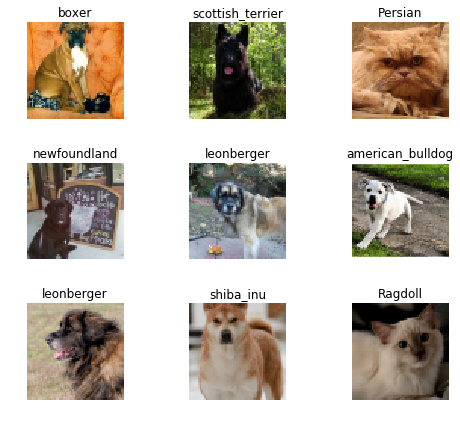

In [12]:
data.show_batch(rows=3, figsize=(7,6))

In [13]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [14]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,4.019575,3.466700,0.910000


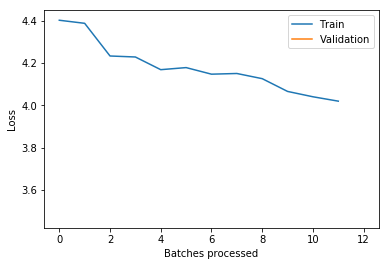

In [15]:
learn.recorder.plot_losses()

### data block

In [62]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='cat1')
        .transform(tfms, size=64)).databunch()

KeyboardInterrupt: 

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [120]:
src=(ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))

In [17]:
learn = create_cnn(data, models.resnet18, metrics=error_rate)
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [18]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,4.153660,4.150504,1.000000


## multiclass 

In [70]:
df=df_full[['img', 'mcat1', 'is_valid']]
df.head()

,img,mcat1,is_valid
0,pug_106,x z,False
1,japanese_chin_35,x,False
2,Bombay_157,x,False
3,British_Shorthair_98,z x,False
4,american_bulldog_23,,False


### databunch factory method

In [71]:
data = ImageDataBunch.from_df(path, df, folder='images', suffix='.jpg', size=64, label_delim=' ')

> /Users/yang.zhang/git/fastai/fastai/data_block.py(238)_label_from_list()
-> y = label_cls(labels, path=self.path, **kwargs)
(Pdb) label_cls
<class 'fastai.data_block.MultiCategoryList'>
(Pdb) labels
array(['x', 'x', 'z x', 'z y', ..., '', 'z y', '', 'z'], dtype=object)
(Pdb) kwargs
{'label_delim': ' '}
(Pdb) q


BdbQuit: 

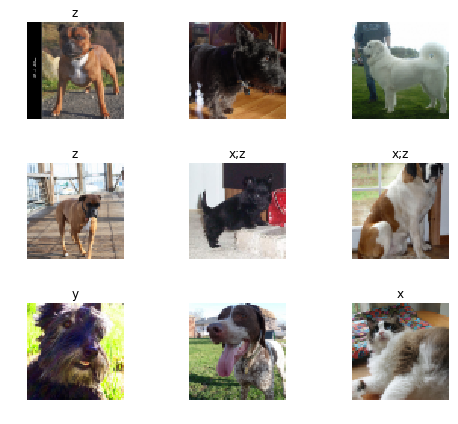

In [23]:
data.show_batch(rows=3, figsize=(7,6))

In [24]:
learn = create_cnn(data, models.resnet18)
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [25]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss
1,0.837814,0.742480


### data block

In [26]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='mcat1', label_delim=' ')
        .transform(tfms, size=64)).databunch()

In [ ]:
# debug
src=(ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))
def dbg():
    breakpoint()
    src.label_from_df(cols='mcat1', label_delim=' ')
dbg()

In [29]:
learn = create_cnn(data, models.resnet18)
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

In [30]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss
1,0.811517,0.737025


## regression

In [31]:
df=df_full[['img', 'num1', 'is_valid']]
df.head()

,img,num1,is_valid
0,pug_106,0.851944,False
1,japanese_chin_35,0.768339,False
2,Bombay_157,0.554693,False
3,British_Shorthair_98,0.733173,False
4,american_bulldog_23,-1.104222,False


### databunch factory method

In [32]:
# doesn't work
# data = ImageDataBunch.from_df(path, df[['img', 'num1']], folder='images', suffix='.jpg', size=64)

### data block

In [33]:
data = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid')
        .label_from_df(cols='num1')
        .transform(tfms, size=64)).databunch()

In [34]:
learn = create_cnn(data, models.resnet18, metrics=mse)
learn.loss_func

FlattenedLoss of MSELoss()

In [35]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,mean_squared_error
1,1.831803,1.286596,1.286596


# multi task

https://docs.fast.ai/tutorial.itemlist.html

## 2 single-classes

In [16]:
df=df_full[['img', 'cat1', 'cat2', 'is_valid']]
df.head()

,img,cat1,cat2,is_valid
0,samoyed_200,samoyed,A,False
1,pug_78,pug,B,False
2,shiba_inu_37,shiba_inu,A,False
3,pug_118,pug,A,True
4,american_bulldog_95,american_bulldog,A,True


In [17]:
src = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))

type(src), type(src.train)

(fastai.data_block.ItemLists, fastai.vision.data.ImageItemList)

In [18]:
class MultitaskProcessor(PreProcessor):
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes_cat1, ds.classes_cat2)
        self.warns = []

    def create_classes(self, classes_cat1, classes_cat2):
        self.classes_cat1,self.classes_cat2 = classes_cat1,classes_cat2
        self.c2i_cat1 = {v:k for k,v in enumerate(classes_cat1)}
        self.c2i_cat2 = {v:k for k,v in enumerate(classes_cat2)}

    def process_one(self,item):
        if isinstance(item, EmptyLabel): return item
        res_cat1 = self.c2i_cat1.get(item[0],None)
        res_cat2 = self.c2i_cat2.get(item[1],None)
        if res_cat1 is None or res_cat2 is None: self.warns.append(str(item))
        return res_cat1,res_cat2

    def process(self, ds):
        ds.c2i_cat1 = self.c2i_cat1
        ds.c2i_cat1 = self.c2i_cat1
        super().process(ds)


class MultitaskList(ItemList):
    _processor=MultitaskProcessor
    def __init__(self, items, **kwargs):
        self.classes_cat1=sorted(set(np.array(items)[:,0]))
        self.classes_cat2=sorted(set(np.array(items)[:,1]))
        self.c_cat1,self.c_cat2=len(self.classes_cat1), len(self.classes_cat2)
        self.filter_missing_y=True
        super().__init__(items, **kwargs)
    @property
    def c(self): return self.c_cat1+self.c_cat2

In [19]:
from types import MethodType
def label_from_df_mtsk(self, label_cls=MultitaskList, **kwargs):
    labels = self.inner_df[['cat1', 'cat2']]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it." 
    return self._label_from_list(labels.values, label_cls, **kwargs)

for ll in (src.train, src.valid):
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)

In [20]:
src = src.label_from_df_mtsk()
src

LabelLists;

Train: LabelList (795 items)
x: ImageItemList
Image (3, 375, 500),Image (3, 333, 500),Image (3, 435, 443),Image (3, 500, 332),Image (3, 500, 250)
y: MultitaskList
[31  0],[29  1],[33  0],[28  1],[5 0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (205 items)
x: ImageItemList
Image (3, 500, 332),Image (3, 332, 500),Image (3, 262, 260),Image (3, 500, 333),Image (3, 290, 300)
y: MultitaskList
[29  0],[12  0],[0 0],[26  1],[17  0]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [21]:
src.train.y.c_cat1, src.train.y.c_cat2, src.train.y.c

(37, 2, 39)

In [22]:
src = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))
for ll in (src.train, src.valid):
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
src = src.label_from_df_mtsk()
src

LabelLists;

Train: LabelList (795 items)
x: ImageItemList
Image (3, 375, 500),Image (3, 333, 500),Image (3, 435, 443),Image (3, 500, 332),Image (3, 500, 250)
y: MultitaskList
[31  0],[29  1],[33  0],[28  1],[5 0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (205 items)
x: ImageItemList
Image (3, 500, 332),Image (3, 332, 500),Image (3, 262, 260),Image (3, 500, 333),Image (3, 290, 300)
y: MultitaskList
[29  0],[12  0],[0 0],[26  1],[17  0]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [23]:
src.valid.y

MultitaskList (205 items)
[29  0],[12  0],[0 0],[26  1],[17  0]
Path: ~/data/fastai/oxford-iiit-pet

In [24]:
src=src.transform(tfms, size=64)
src

LabelLists;

Train: LabelList (795 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[31  0],[29  1],[33  0],[28  1],[5 0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (205 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[29  0],[12  0],[0 0],[26  1],[17  0]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [25]:
src.databunch()

ImageDataBunch;

Train: LabelList (795 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[31  0],[29  1],[33  0],[28  1],[5 0]
Path: ~/data/fastai/oxford-iiit-pet;

Valid: LabelList (205 items)
x: ImageItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultitaskList
[29  0],[12  0],[0 0],[26  1],[17  0]
Path: ~/data/fastai/oxford-iiit-pet;

Test: None

In [26]:
data = src.databunch()

In [27]:
# data.show_batch(rows=3, figsize=(7,6))

In [32]:
c_cat1,c_cat2=data.c_cat1, data.c_cat2

def multitask_loss(input, target):
    input_cat1 = input[:,:c_cat1]
    input_cat2 = input[:,c_cat1:c_cat1+c_cat2]
    target_cat1,target_cat2 = target[:,0],target[:, 1]
    loss_cat1 = F.cross_entropy(input_cat1, target_cat1.long())
    loss_cat2 = F.cross_entropy(input_cat2, target_cat2.long())
    print(loss_cat1, loss_cat2)
    return loss_cat1 + loss_cat2

In [33]:
learn = create_cnn(data, models.resnet18, metrics=error_rate, loss_func=multitask_loss)
learn.loss_func

<function __main__.multitask_loss(input, target)>

In [34]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,3.966740,3.478232,0.929268


tensor(4.2381, grad_fn=<NllLossBackward>) tensor(0.8912, grad_fn=<NllLossBackward>)
tensor(4.1687, grad_fn=<NllLossBackward>) tensor(0.7452, grad_fn=<NllLossBackward>)
tensor(4.0624, grad_fn=<NllLossBackward>) tensor(0.9669, grad_fn=<NllLossBackward>)
tensor(4.0340, grad_fn=<NllLossBackward>) tensor(1.0923, grad_fn=<NllLossBackward>)
tensor(4.1301, grad_fn=<NllLossBackward>) tensor(0.8953, grad_fn=<NllLossBackward>)
tensor(3.8527, grad_fn=<NllLossBackward>) tensor(0.7564, grad_fn=<NllLossBackward>)
tensor(3.7257, grad_fn=<NllLossBackward>) tensor(0.7587, grad_fn=<NllLossBackward>)
tensor(3.8086, grad_fn=<NllLossBackward>) tensor(0.8311, grad_fn=<NllLossBackward>)
tensor(3.9974, grad_fn=<NllLossBackward>) tensor(0.8274, grad_fn=<NllLossBackward>)
tensor(3.8377, grad_fn=<NllLossBackward>) tensor(0.9075, grad_fn=<NllLossBackward>)
tensor(3.8747, grad_fn=<NllLossBackward>) tensor(0.8788, grad_fn=<NllLossBackward>)
tensor(3.9557, grad_fn=<NllLossBackward>) tensor(0.7736, grad_fn=<NllLossBac

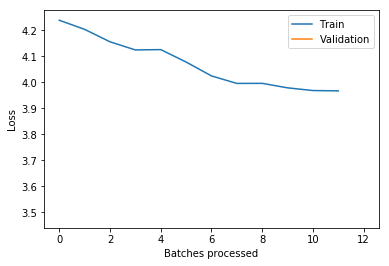

In [35]:
learn.recorder.plot_losses()

In [37]:
pred_val, y_val=learn.get_preds()

In [38]:
pred_val.shape, y_val.shape

(torch.Size([205, 39]), torch.Size([205, 2]))

In [39]:
pred_val

tensor([[-0.9001,  0.2603,  0.8087,  ..., -0.7940, -0.1799, -0.0158],
        [-0.0634, -0.0539,  0.3654,  ...,  0.2887, -0.4941, -0.3853],
        [ 0.2585,  0.4585,  0.1120,  ...,  0.6811,  0.1196, -0.1341],
        ...,
        [-0.2841,  0.1717,  0.2085,  ..., -0.0310,  0.3840,  0.1496],
        [-0.5468,  0.1761, -0.1677,  ..., -0.3167, -1.0948, -0.3209],
        [ 0.8536,  0.0149, -0.2329,  ...,  0.3078,  0.3360,  0.4066]])

In [40]:
y_val

tensor([[29,  0],
        [12,  0],
        [ 0,  0],
        [26,  1],
        [17,  0],
        [35,  1],
        [ 8,  1],
        [ 1,  1],
        [21,  1],
        [31,  1],
        [12,  0],
        [24,  1],
        [ 9,  1],
        [ 6,  1],
        [ 2,  0],
        [26,  0],
        [ 7,  1],
        [ 1,  1],
        [ 5,  1],
        [ 3,  0],
        [18,  0],
        [18,  1],
        [36,  0],
        [11,  1],
        [ 6,  1],
        [20,  0],
        [27,  0],
        [26,  0],
        [20,  0],
        [26,  1],
        [19,  0],
        [27,  0],
        [ 4,  0],
        [26,  1],
        [35,  1],
        [31,  0],
        [ 0,  1],
        [24,  0],
        [ 6,  0],
        [23,  0],
        [14,  0],
        [20,  0],
        [28,  1],
        [27,  1],
        [32,  0],
        [16,  1],
        [ 7,  0],
        [21,  1],
        [30,  1],
        [24,  0],
        [11,  0],
        [ 0,  0],
        [19,  0],
        [30,  1],
        [22,  1],
        [1

### put together

In [45]:
class MultitaskProcessor(PreProcessor):
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes_cat1, ds.classes_cat2)
        self.warns = []

    def create_classes(self, classes_cat1, classes_cat2):
        self.classes_cat1,self.classes_cat2 = classes_cat1,classes_cat2
        self.c2i_cat1 = {v:k for k,v in enumerate(classes_cat1)}
        self.c2i_cat2 = {v:k for k,v in enumerate(classes_cat2)}

    def process_one(self,item):
        if isinstance(item, EmptyLabel): return item
        res_cat1 = self.c2i_cat1.get(item[0],None)
        res_cat2 = self.c2i_cat2.get(item[1],None)
        if res_cat1 is None or res_cat2 is None: self.warns.append(str(item))
        return res_cat1,res_cat2

    def process(self, ds):
        ds.c2i_cat1 = self.c2i_cat1
        ds.c2i_cat1 = self.c2i_cat1
        super().process(ds)


class MultitaskList(ItemList):
    _processor=MultitaskProcessor
    def __init__(self, items, **kwargs):
        self.classes_cat1=sorted(set(np.array(items)[:,0]))
        self.classes_cat2=sorted(set(np.array(items)[:,1]))
        self.c_cat1,self.c_cat2=len(self.classes_cat1), len(self.classes_cat2)
        self.filter_missing_y=True
        super().__init__(items, **kwargs)
    @property
    def c(self): return self.c_cat1+self.c_cat2

from types import MethodType
def label_from_df_mtsk(self, label_cls=MultitaskList, **kwargs):
    labels = self.inner_df[['cat1', 'cat2']]
    assert labels.isna().sum().sum() == 0, f"You have NaN values in column(s) {cols} of your dataframe, please fix it." 
    return self._label_from_list(labels.values, label_cls, **kwargs)


c_cat1,c_cat2=data.c_cat1, data.c_cat2
def multitask_loss(input, target):
    input_cat1 = input[:,:c_cat1]
    input_cat2 = input[:,c_cat1:c_cat1+c_cat2]
    target_cat1,target_cat2 = target[:,0],target[:, 1]
    loss_cat1 = F.cross_entropy(input_cat1, target_cat1.long())
    loss_cat2 = F.cross_entropy(input_cat2, target_cat2.long())
    return loss_cat1 + loss_cat2

In [46]:
src = (ImageItemList.from_df(df, path, folder='images', suffix='.jpg')
        .split_from_df(col='is_valid'))

for ll in (src.train, src.valid):
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)
    ll.label_from_df_mtsk = MethodType(label_from_df_mtsk, ll)

data = (src.label_from_df_mtsk()
        .transform(tfms, size=64)
        .databunch())

In [47]:
learn = create_cnn(data, models.resnet18, metrics=error_rate, loss_func=multitask_loss)
learn.loss_func

<function __main__.multitask_loss(input, target)>

In [48]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,5.018440,4.272307,0.951219


tensor(4.1337, grad_fn=<NllLossBackward>) tensor(0.8886, grad_fn=<NllLossBackward>)
tensor(4.0884, grad_fn=<NllLossBackward>) tensor(0.8744, grad_fn=<NllLossBackward>)
tensor(4.2142, grad_fn=<NllLossBackward>) tensor(1.0315, grad_fn=<NllLossBackward>)
tensor(4.1558, grad_fn=<NllLossBackward>) tensor(0.8786, grad_fn=<NllLossBackward>)
tensor(4.2819, grad_fn=<NllLossBackward>) tensor(0.8411, grad_fn=<NllLossBackward>)
tensor(4.3404, grad_fn=<NllLossBackward>) tensor(1.0279, grad_fn=<NllLossBackward>)
tensor(3.8973, grad_fn=<NllLossBackward>) tensor(1.1016, grad_fn=<NllLossBackward>)
tensor(3.9500, grad_fn=<NllLossBackward>) tensor(0.9229, grad_fn=<NllLossBackward>)
tensor(4.1468, grad_fn=<NllLossBackward>) tensor(0.9657, grad_fn=<NllLossBackward>)
tensor(3.8091, grad_fn=<NllLossBackward>) tensor(0.9428, grad_fn=<NllLossBackward>)
tensor(3.8332, grad_fn=<NllLossBackward>) tensor(0.9639, grad_fn=<NllLossBackward>)
tensor(3.9942, grad_fn=<NllLossBackward>) tensor(0.9991, grad_fn=<NllLossBac

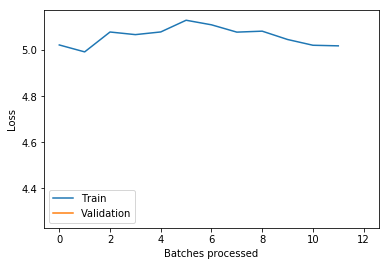

In [49]:
learn.recorder.plot_losses()

In [50]:
pred_val, y_val=learn.get_preds()

In [51]:
pred_val.shape, y_val.shape

(torch.Size([205, 39]), torch.Size([205, 2]))